# Setup and Imports

In [ ]:
!pip install LPIPS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/53.8 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset  # Make sure to import Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from lpips import LPIPS

# Initialize LPIPS metric
# lpips_metric = LPIPS(net='vgg').cuda()

# Data Preprocessing

In [ ]:
# Define transformations for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 for faster training
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load the CIFAR-10 training set
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# TODO: select 3 categories as training dataset
selected_classes = -1
selected_class_indices = [0, 1, 2]

# Collect 100 images for each class
subset_indices = []
class_counts = {index: 0 for index in selected_class_indices}

for idx, (image, label) in enumerate(cifar10_train):
    if label in selected_class_indices and class_counts[label] < 100:
        subset_indices.append(idx)
        class_counts[label] += 1
    if all(count >= 100 for count in class_counts.values()):
        break

# Create a subset for training
cifar10_subset = Subset(cifar10_train, subset_indices)
train_loader = DataLoader(cifar10_subset, batch_size=4, shuffle=True)

 15%|█▍        | 25460736/170498071 [00:15<01:08, 2103013.31it/s]

# Define the Generator and Discriminator

In [ ]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # TODO: define a UNet-like generator
        self.encoder = 
        self.decoder = 

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()
        # TODO: define a simple PatchGAN discriminator
        self.model =

    def forward(self, x):
        return self.model(x)

# Model Training

In [65]:
generator = UNetGenerator().cuda()
discriminator = PatchGANDiscriminator().cuda()

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Track losses for plotting
g_losses, d_losses = [], []

def train():
    generator.train()
    for epoch in range(1000):  # Train for 20 epochs
        g_loss_epoch, d_loss_epoch = 0, 0
        for i, (input_img, _) in enumerate(train_loader):
            target_img = input_img  # Using the same images as targets for simplicity
            input_img, target_img = input_img.cuda(), target_img.cuda()

            # Train Discriminator
            optimizer_D.zero_grad()
            fake_img = generator(input_img)
            real_data = torch.cat((input_img, target_img), 1)
            fake_data = torch.cat((input_img, fake_img.detach()), 1)
            real_loss = criterion_GAN(discriminator(real_data), torch.ones_like(discriminator(real_data)).cuda())
            fake_loss = criterion_GAN(discriminator(fake_data), torch.zeros_like(discriminator(fake_data)).cuda())
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss_GAN = criterion_GAN(discriminator(fake_data), torch.ones_like(discriminator(fake_data)).cuda())
            g_loss_L1 = criterion_L1(fake_img, target_img)
            g_loss = g_loss_GAN + 100 * g_loss_L1
            g_loss.backward()
            optimizer_G.step()

            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()

        # Record average losses per epoch
        g_losses.append(g_loss_epoch / len(train_loader))
        d_losses.append(d_loss_epoch / len(train_loader))
        print(f"Epoch [{epoch+1}/1000], D Loss: {d_losses[-1]:.4f}, G Loss: {g_losses[-1]:.4f}")

train()


Epoch [1/1000], D Loss: 0.6661, G Loss: 17.2069
Epoch [2/1000], D Loss: 0.6720, G Loss: 9.2894
Epoch [3/1000], D Loss: 0.6564, G Loss: 7.9308
Epoch [4/1000], D Loss: 0.6274, G Loss: 7.4583
Epoch [5/1000], D Loss: 0.5914, G Loss: 6.8454
Epoch [6/1000], D Loss: 0.5578, G Loss: 6.7759
Epoch [7/1000], D Loss: 0.5181, G Loss: 6.4759
Epoch [8/1000], D Loss: 0.4933, G Loss: 6.1694
Epoch [9/1000], D Loss: 0.4844, G Loss: 6.0211
Epoch [10/1000], D Loss: 0.4184, G Loss: 6.2851
Epoch [11/1000], D Loss: 0.4311, G Loss: 6.3629
Epoch [12/1000], D Loss: 0.3855, G Loss: 6.3178
Epoch [13/1000], D Loss: 0.3479, G Loss: 6.5344
Epoch [14/1000], D Loss: 0.3664, G Loss: 6.8118
Epoch [15/1000], D Loss: 0.3947, G Loss: 6.1846
Epoch [16/1000], D Loss: 0.3024, G Loss: 6.7013
Epoch [17/1000], D Loss: 0.3756, G Loss: 6.6973
Epoch [18/1000], D Loss: 0.3856, G Loss: 6.0818
Epoch [19/1000], D Loss: 0.2478, G Loss: 7.3746
Epoch [20/1000], D Loss: 0.3146, G Loss: 7.1775
Epoch [21/1000], D Loss: 0.3063, G Loss: 6.7044


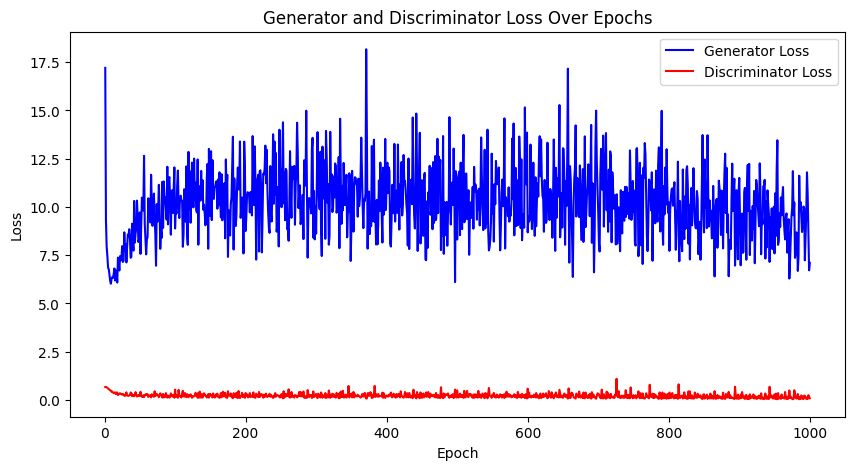

In [66]:
# TODO: plot Generator and Discriminator loss, Epoch=1000


# Result

## Quantitative analysis

In [62]:
# TODO: define evaluate function to print evaluation result of PSNR/SSIM/LPIPS
def evaluate():
    

In [67]:
# Epoch=1000
evaluate()

Average PSNR: 25.13
Average SSIM: 0.9728
Average LPIPS: 0.0037


## Qualitative analysis

In [ ]:
# TODO: define visualization function for Qualitative analysis.
# Select 4 images of each inference from 3 categories
def inference_and_visualize():

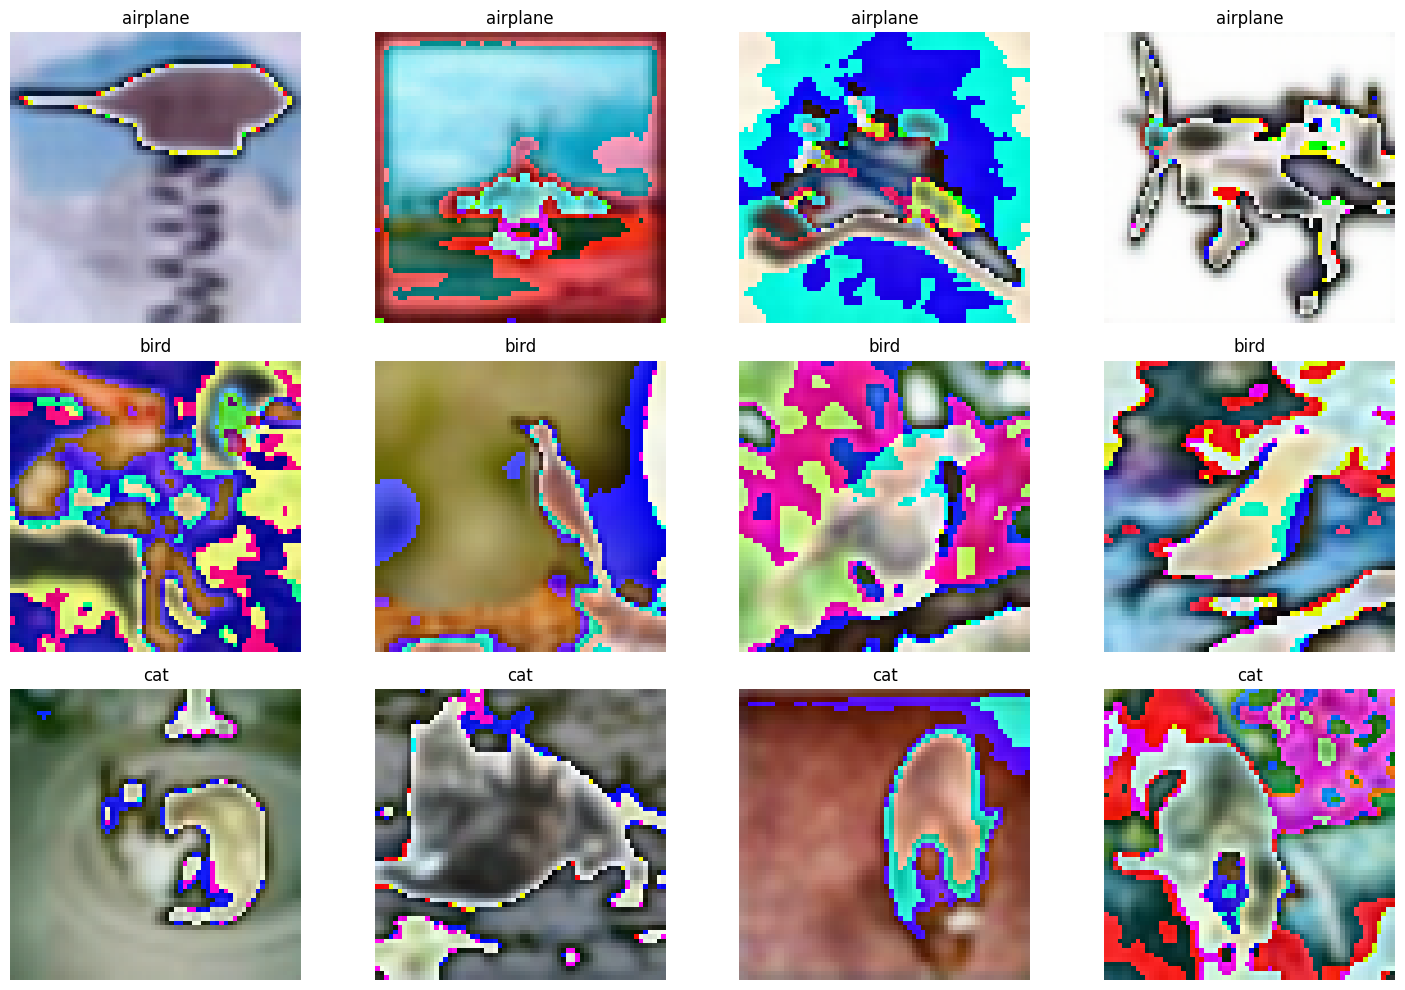

In [68]:
# Epoch=1000
inference_and_visualize()